# Exercise: Below is the same code as we discussed for the MLP. Please modify and extend it as below:

## 1. Instead of an MLP, initialize a CNN as below and train the model:
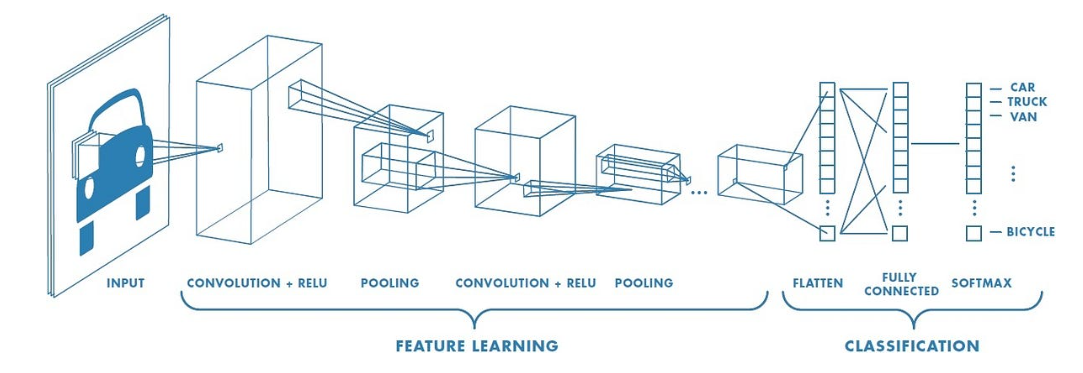
| Layer type   | size    | Output channels  | Stride |
|--------------|---------|------------------|--------|
| conv         | 5x5     | 6                | 1      |
| relu         |     |                  |       |
| pool         | 2x2     |                  | 2      |
| conv         | 5x5     | 16               | 1      |
| relu         |     |                  |       |
| pool         | 2x2     |                  | 2      |
| fully connected   |      | 256               |       |
| relu         |     |                  |       |
| fully connected   |      | 120               |       |
| relu         |     |                  |       |
| fully connected   |      | 84               |       |
| relu         |     |                  |       |
| fully connected   |      | 10               |       |

## 2. We already show one example from the test set and it's prediction. Can you get the prediction results for all images in the test set and show some examples where the predictions are wrong?

### Import relevant packages

In [44]:
#Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary

#Sci-kit learn
import sklearn.model_selection

#Numpy
import numpy as np

#IPython
from IPython.display import clear_output

#Matplotlib
import matplotlib.pyplot as plt

#Dataset
from mlxtend.data import mnist_data



### Download training data from open datasets




In [45]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

### Check some of the properties of the data set

In [46]:
classes = training_data.classes
print(classes)

num_training_samples = len(training_data)
print(f"Number of samples in the training data: {num_training_samples}")

num_test_samples = len(test_data)
print(f"Number of samples in the test data: {num_test_samples}")


['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Number of samples in the training data: 60000
Number of samples in the test data: 10000


### Setting up the data sets for training and testing

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


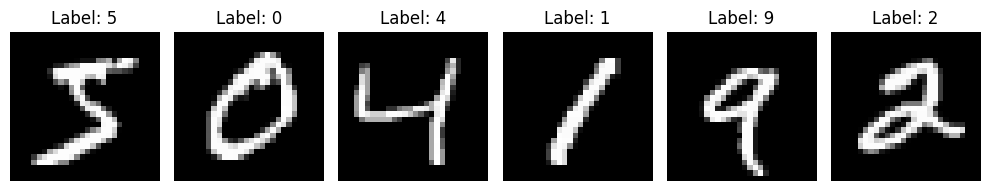

In [47]:
batch_size = 64 # we will talk about it later

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")

    fig, axes = plt.subplots(1, 6, figsize=(10, 10))
    axes = axes.flatten()

    for i in range(6):
        img = X[i].squeeze().numpy()
        axes[i].imshow(img, cmap="gray")
        axes[i].set_title(f"Label: {y[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    break

### Defining a simple convolutional network architecture

| Layer type   | size    | Output channels  | Stride |
|--------------|---------|------------------|--------|
| conv         | 5x5     | 6                | 1      |
| relu         |     |                  |       |
| pool         | 2x2     |                  | 2      |
| conv         | 5x5     | 16               | 1      |
| relu         |     |                  |       |
| pool         | 2x2     |                  | 2      |
| fully connected   |      | 256               |       |
| relu         |     |                  |       |
| fully connected   |      | 120               |       |
| relu         |     |                  |       |
| fully connected   |      | 84               |       |
| relu         |     |                  |       |
| fully connected   |      | 10               |       |




In [48]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda" if torch.cuda.is_available()
     else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #Convolutional Layers
        self.Conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5,stride=1)
        self.Conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5,stride=1)
        #Pooling Layers
        self.Pool = nn.MaxPool2d(kernel_size=2,stride=2)
        #Linear Layers
        self.Linear1 = nn.Linear(in_features=256,out_features=256)
        self.Linear2 = nn.Linear(in_features=256,out_features=120)
        self.Linear3 = nn.Linear(in_features=120,out_features=84)
        self.Linear4 = nn.Linear(in_features=84,out_features=10)

        #Activation Functions
        self.ReLU = nn.ReLU(inplace=True)

        #Flattening Function
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.Conv1(x)
        x = self.ReLU(x)
        x = self.Pool(x)
        x = self.Conv2(x)
        x = self.ReLU(x)
        x = self.Pool(x)
        x = self.flatten(x)
        x = self.Linear1(x)
        x = self.ReLU(x)
        x = self.Linear2(x)
        x = self.ReLU(x)
        x = self.Linear3(x)
        x = self.ReLU(x)
        logits = self.Linear4(x)

        return logits

model = NeuralNetwork().to(device)
print(model)


Using cuda device
NeuralNetwork(
  (Conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (Conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (Pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Linear1): Linear(in_features=256, out_features=256, bias=True)
  (Linear2): Linear(in_features=256, out_features=120, bias=True)
  (Linear3): Linear(in_features=120, out_features=84, bias=True)
  (Linear4): Linear(in_features=84, out_features=10, bias=True)
  (ReLU): ReLU(inplace=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)


### We can also see the model parameters and the size at each layer of the model
This is done by using the pytorchsummary package https://github.com/sksq96/pytorch-summary

In [49]:
summary(model, input_size=(1, 28, 28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 24, 24]             156
              ReLU-2            [-1, 6, 24, 24]               0
         MaxPool2d-3            [-1, 6, 12, 12]               0
            Conv2d-4             [-1, 16, 8, 8]           2,416
              ReLU-5             [-1, 16, 8, 8]               0
         MaxPool2d-6             [-1, 16, 4, 4]               0
           Flatten-7                  [-1, 256]               0
            Linear-8                  [-1, 256]          65,792
              ReLU-9                  [-1, 256]               0
           Linear-10                  [-1, 120]          30,840
             ReLU-11                  [-1, 120]               0
           Linear-12                   [-1, 84]          10,164
             ReLU-13                   [-1, 84]               0
           Linear-14                   

### Defining a loss-function

Let’s use a Classification Cross-Entropy loss SGD.
Our labels are one-hot encoded, which means that for each image, we have a target vector with 10 entries (one for each class).
This target vector contains only zeros except for the entry of the class to which the image belongs.

\begin{equation}
H(y,\hat y) = -\sum_j y_j \cdot log(\hat y_j)
\end{equation}

$j \in \{1, 2, \dots, n_{\text{classes}}\}$ and $\hat{y}_j = \begin{cases}
    1 & \text{if } j = \text{true class}, \\
    0 & \text{otherwise}
\end{cases}$

Explanation: Let’s assume a simple case where we have three classes. The true label vector y for a given sample is [0, 0, 1] (indicating class 3 is the correct label), and the model outputs a probability distribution p = [0.1, 0.3, 0.6].

\begin{equation}
\text{Loss} = -[0 \times \log(0.1) + 0 \times \log(0.3) + 1 \times \log(0.6)] = -\log(0.6) = 0.51
\end{equation}



In [50]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    total_loss, correct = 0, 0  # Track the total loss for the epoch

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        total_loss += loss.item()  # Accumulate loss

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Calculate accuracy
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        #if batch % 100 == 0:
        #    loss, current = loss.item(), (batch + 1) * len(X)
        #    print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss = total_loss / len(dataloader)  # Calculate average loss for the epoch
    avg_accuracy = correct / size

    train_losses.append(avg_loss)  # Store the average loss for the epoch
    train_accuracies.append(avg_accuracy) # Store the average accuracy for the epoch

    print(f"Train loss: {avg_loss:>7f}, Accuracy: {(100*avg_accuracy):>0.1f}%")

In [56]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_losses.append(test_loss)  # Store the test loss for the epoch
    test_accuracies.append(correct)

    print(f"Test Error: \n Avg loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}% \n")

In [61]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

model = NeuralNetwork().to(device)

learning_rate = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Let's use stocastic gradient descent (We will talk about it in the coming weeks)


epochs = 6
for t in range(epochs):
    if t % 4 == 0:
        clear_output(wait=True)
    
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


Epoch 5
-------------------------------
Train loss: 0.095593, Accuracy: 97.8%
Test Error: 
 Avg loss: 0.088525, Accuracy: 98.1% 

Epoch 6
-------------------------------
Train loss: 0.106098, Accuracy: 97.6%
Test Error: 
 Avg loss: 0.125646, Accuracy: 97.5% 

Done!


# Check the performance of the network through train and test loss and accuracy curves

Write your code below to plot the training and test loss and accuracy for each epoch.

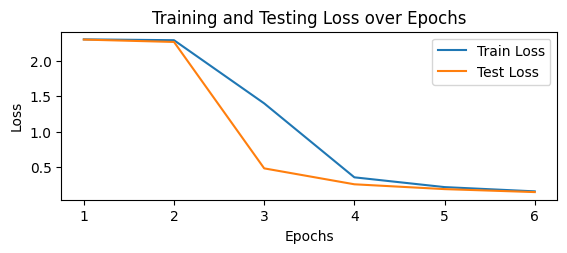

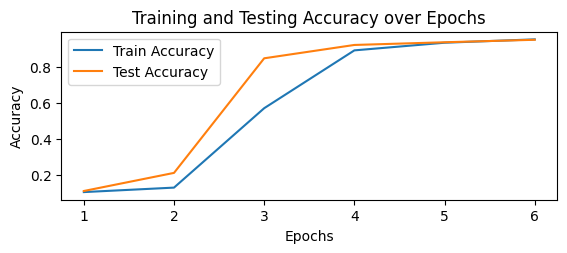

In [58]:
plt.subplot(2,1,1)
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Loss over Epochs")
plt.legend()
plt.show()

plt.subplot(2,1,2)
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, epochs+1), test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.legend()
plt.show()


# Check result for one image

Predicted: "7 - seven", Actual: "7 - seven"


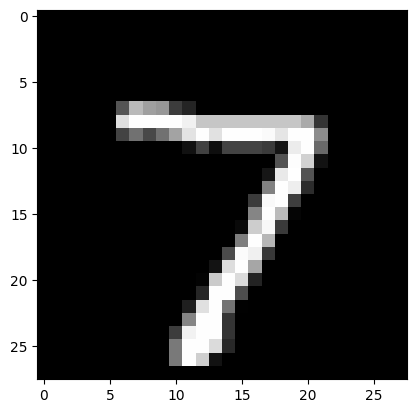

In [59]:
model.eval()
idx = 0
x, y = test_data[idx][0], test_data[idx][1]
plt.imshow(x.permute(1,2,0), cmap = 'gray')
with torch.no_grad():
    x = x.to(device)
    pred = model(x.unsqueeze(0))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')


### prediction results for all images in the test set and show some examples where the predictions are wrong

In [60]:
model.eval()

#YOUR CODE HERE

NeuralNetwork(
  (Conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (Conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (Pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Linear1): Linear(in_features=256, out_features=256, bias=True)
  (Linear2): Linear(in_features=256, out_features=120, bias=True)
  (Linear3): Linear(in_features=120, out_features=84, bias=True)
  (Linear4): Linear(in_features=84, out_features=10, bias=True)
  (ReLU): ReLU(inplace=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

# EXTRA: Use your own data and try implementing AlexNet
Try training a network on your own classes, e.g., cats and dogs. You can use the following library to scrape images from google image search.
https://pypi.org/project/simple-image-download/


You can also find many datasets on https://www.kaggle.com/datasets

A good starting point is to use the `ImageFolder` dataset, which lets you define an image dataset as folders with names that indicate labels.
https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

You might also have to modify the `transformer`, which preprocesses the images. So far we have only used it to convert them to tensors, but it can also be used to resize images (and much more):
```
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((32,32)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]).
```

See https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html